In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import plotting as myplt
%matplotlib inline

In [2]:
def create_NN_graph(nNodes,kij):
    
    G = nx.Graph()
    
    elist = []
    for i in range(nNodes-1):
        edge_tuple = (i,i+1,kij)
        elist.append(edge_tuple)
    G.add_weighted_edges_from(elist)
    return G

def create_NN_k_matrix(nNodes,kij):
    
    k = np.zeros((nNodes,nNodes),dtype=float)
    
    for i in range(nNodes-1):
        k[i,i+1] = k[i+1,i] =  kij
    return k

def create_bottleneck_k_matrix(nNodes,kij):
    
    k = np.zeros((nNodes,nNodes),dtype=float)

    for i in range(nNodes-1):
        for j in range(i+1,nNodes):
            # nearest neighbors are bonded
            if (abs(i-j)<2):
                k[i,j] = kij
            elif i < nNodes//2 and j < nNodes//2:
                k[i,j] = kij
            elif i > nNodes//2 and j > nNodes//2:
                k[i,j] = kij
            # symmetrize
            k[j,i] = k[i,j]
    return k

def k_to_hessian(k):
    hessian = -k
    for i in range(hessian.shape[0]):
        hessian[i,i] = -np.sum(hessian[i,:])
    return hessian

def compute_correlation_from_hessian(hess):
    M = hess.shape[0]
    hess_evals, hess_evecs = np.linalg.eigh(hess)
    # this translates to the following matrix equations
    gamma = np.diag(1.0/hess_evals)
    gamma[0,0] = 0.
    covar_from_hessian = np.dot(hess_evecs,np.dot(gamma,hess_evecs.T))*0.8
    analytic_corr = covar_to_correlation(covar_from_hessian)
    return analytic_corr, covar_from_hessian

def covar_to_correlation(covar):
    M = covar.shape[0]
    corr = np.empty((M,M),dtype=float)
    for i in range(M):
        for j in range(M):
             corr[i,j] = covar[i,j]/(np.sqrt(covar[i,i]*covar[j,j]))
    return corr

In [3]:
def centrality(A,n):
    e, v = np.linalg.eigh(A)
    centrality = np.zeros(A.shape[0])
    for i in range(1,n+1):
        centrality += 1.0/e[-i]*np.dot(A,v[:,-i])
    cmax = np.amax(-centrality)
    cmin = np.amin(-centrality)
    return 2 * (-centrality-cmin)/(cmax-cmin) - 1
    #return -centrality

## Nearest Neighbor Graph

In [5]:
# generate two adjacency matrices and save to file
nnk = create_NN_k_matrix(9,100.0)
nnHess = k_to_hessian(nnk)
nnCorr, nnCovar = compute_correlation_from_hessian(nnHess)
nnCombined = np.copy(nnk)
for i in range(nnCombined.shape[0]-1):
    for j in range(i+1,nnCombined.shape[1]):
        nnCombined[j,i] /= np.sqrt(nnHess[i,i]*nnHess[j,j])
        nnk[j,i] /= np.sqrt(nnHess[i,i]*nnHess[j,j])
        nnk[i,j] = nnk[j,i]
        nnCombined[i,j] = abs(nnCorr[i,j])
myplt.plot_square_matrix(nnCombined,"nearest_neighbor_hessian_corr_hot.png",axes_label='Nodes',v_range=[0,1],minor_ticks=1,major_ticks=1,plotting_cmap='hot_r')

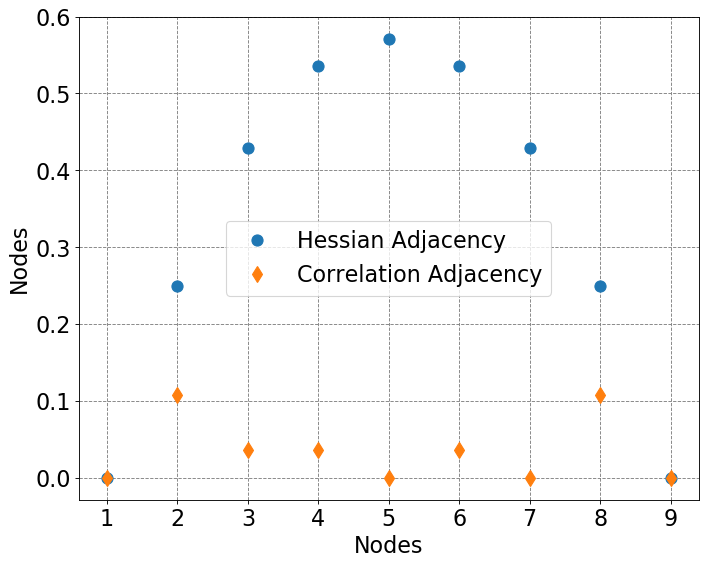

In [6]:
# plot betweenness centralities
nnkA = np.zeros(nnk.shape,dtype=float)
nnCorrA = np.zeros(nnk.shape,dtype=float)
for i in range(nnk.shape[0]-1):
    for j in range(i+1,nnk.shape[1]):
        if nnk[i,j]>0:
            nnkA[i,j] = -np.log(nnk[i,j]/np.sqrt(nnHess[i,i]*nnHess[j,j]))
            nnkA[j,i] = nnkA[i,j]
        if abs(nnCorr[i,j]) > 0:
            nnCorrA[i,j] = -np.log(abs(nnCorr[i,j]))
            nnCorrA[j,i] = nnCorrA[i,j]
nnkG = nx.from_numpy_matrix(nnkA)
nnk_betweenness = nx.betweenness_centrality(nnkG,weight='weight')
nnCorrG = nx.from_numpy_matrix(nnCorrA)
nnCorr_betweenness = nx.betweenness_centrality(nnCorrG,weight='weight')
ax = myplt.define_figure(xlabel="Node",ylabel="Betweenness Centrality")
ax.plot([x+1 for x in nnk_betweenness.keys()],nnk_betweenness.values(),"o",markersize=10,label="Hessian Adjacency")
ax.plot([x+1 for x in nnCorr_betweenness.keys()],nnCorr_betweenness.values(),"d",markersize=10,label="Correlation Adjacency")
plt.legend(fontsize=20)
plt.savefig("nearest_neighbor_betweenness.png",dpi=600,transparent=True)

## Fully Connected/Complete Graph

In [11]:
# generate and save 2D plot of adjacency matrices
fullk = np.full((9,9),100.0) - np.diag(np.full(9,100.0))
fullHess = k_to_hessian(fullk)
fullCorr, fullCovar = compute_correlation_from_hessian(fullHess)
fullCombined = np.copy(fullk)
for i in range(fullCombined.shape[0]-1):
    for j in range(i+1,fullCombined.shape[1]):
        fullCombined[j,i] /= (np.sqrt(fullHess[i,i]*fullHess[j,j]))
        fullCombined[i,j] = abs(fullCorr[i,j])
myplt.plot_square_matrix(fullCombined,"complete_graph_hessian_corr_hot.png",axes_label='Nodes',v_range=[0,1],minor_ticks=1,major_ticks=1,plotting_cmap='hot_r')

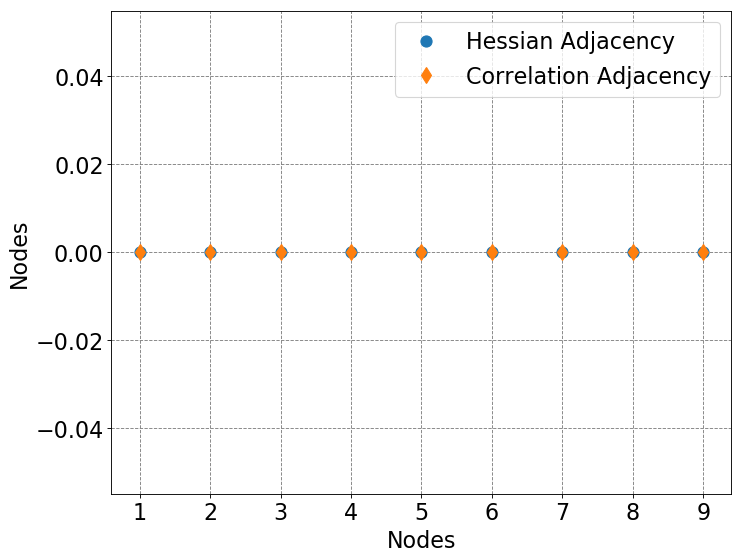

In [8]:
# plot betweenness centrality
fullkA = np.zeros(fullk.shape,dtype=float)
fullCorrA = np.zeros(fullk.shape,dtype=float)
for i in range(fullk.shape[0]-1):
    for j in range(i+1,fullk.shape[1]):
        if fullk[i,j]>0:
            fullkA[i,j] = -np.log(fullk[i,j]/np.sqrt(fullHess[i,i]*fullHess[j,j]))
            fullkA[j,i] = fullkA[i,j]
        if abs(fullCorr[i,j]) > 0:
            fullCorrA[i,j] = -np.log(abs(fullCorr[i,j]))
            fullCorrA[j,i] = fullCorrA[i,j]
fullkG = nx.from_numpy_matrix(fullkA)
fullk_betweenness = nx.betweenness_centrality(fullkG,weight='weight')
fullCorrG = nx.from_numpy_matrix(fullCorrA)
fullCorr_betweenness = nx.betweenness_centrality(fullCorrG,weight='weight')
ax = myplt.define_figure(xlabel="Node",ylabel="Betweenness Centrality")
ax.plot([x+1 for x in fullk_betweenness.keys()],fullk_betweenness.values(),"o",markersize=10,label="Hessian Adjacency")
ax.plot([x+1 for x in fullCorr_betweenness.keys()],fullCorr_betweenness.values(),"d",markersize=10,label="Correlation Adjacency")
plt.legend(fontsize=20)
plt.savefig("complete_graph_betweenness.png",dpi=600,transparent=True)

## Bottleneck Graph

In [12]:
# generate adjacency matrices and save 2D plot
bottlek = create_bottleneck_k_matrix(9,100)
bottleneckHessian = k_to_hessian(bottlek)
bottleneckCorr, bottleneckCovar = compute_correlation_from_hessian(bottleneckHessian)
combined = np.copy(bottlek)
for i in range(combined.shape[0]-1):
    for j in range(i+1,combined.shape[1]):
        combined[j,i] /= (np.sqrt(bottleneckHessian[i,i]*bottleneckHessian[j,j]))
        combined[i,j] = abs(bottleneckCorr[i,j])
myplt.plot_square_matrix(combined,"bottle_neck_hessian_corr_hot.png",axes_label='Nodes',v_range=[0,1],minor_ticks=1,major_ticks=1,plotting_cmap='hot_r')

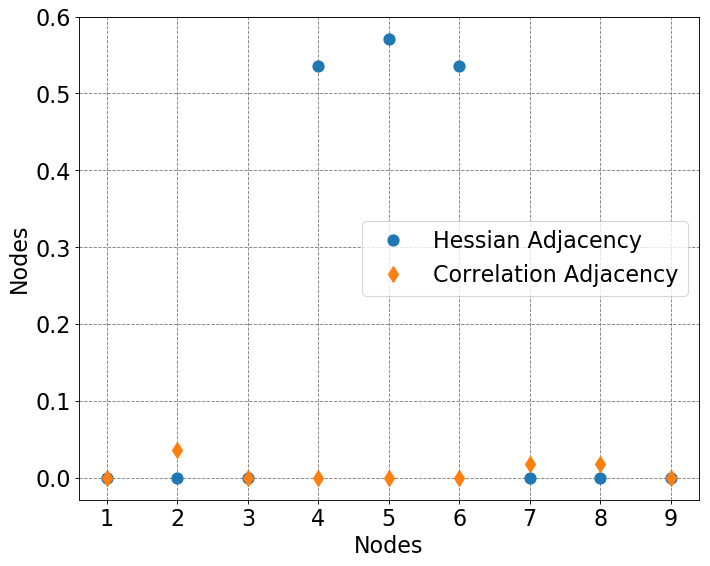

In [10]:
# compute betweenness centrality for both graphs
bottlekA = np.zeros(bottlek.shape,dtype=float)
bottleCorrA = np.zeros(bottlek.shape,dtype=float)
for i in range(bottlek.shape[0]-1):
    for j in range(i+1,bottlek.shape[1]):
        if bottlek[i,j]>0:
            bottlekA[i,j] = -np.log(bottlek[i,j]/np.sqrt(bottleneckHessian[i,i]*bottleneckHessian[j,j]))
            bottlekA[j,i] = bottlekA[i,j]
        if abs(bottleneckCorr[i,j]) > 0:
            bottleCorrA[i,j] = -np.log(abs(bottleneckCorr[i,j]))
            bottleCorrA[j,i] = bottleCorrA[i,j]
bottlekG = nx.from_numpy_matrix(bottlekA)
bottlek_betweenness = nx.betweenness_centrality(bottlekG,weight='weight')
bottleCorrG = nx.from_numpy_matrix(bottleCorrA)
bottleCorr_betweenness = nx.betweenness_centrality(bottleCorrG,weight='weight')
ax = myplt.define_figure(xlabel="Node",ylabel="Betweenness Centrality")
ax.plot([x+1 for x in bottlek_betweenness.keys()],bottlek_betweenness.values(),"o",markersize=10,label="Hessian Adjacency")
ax.plot([x+1 for x in bottleCorr_betweenness.keys()],bottleCorr_betweenness.values(),"d",markersize=10,label="Correlation Adjacency")
plt.legend(fontsize=20)
plt.savefig("bottleneck_graph_betweenness.png",dpi=600,transparent=True)